In [61]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (400., 150.)
from salem import get_demo_file, open_xr_dataset, GeoTiff, wgs84
%matplotlib inline
import glob
from utils import u_darrays as uda, u_arrays as ua
import cartopy.crs as ccrs
import cartopy
import pandas as pd
import ipdb

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [13]:
dat = xr.open_dataset(hfiles[0])

In [3]:
coords = xr.open_dataset('/home/ck/DIR/cornkle/data/NFLICS/LSTA_coords/SEVIRILST_WA_geoloc.nc')

In [16]:
coords

<xarray.Dataset>
Dimensions:        (COLUMN: 3712, ROW: 3712, WA_COLUMN: 1436, WA_ROW: 714)
Coordinates:
  * COLUMN         (COLUMN) int64 0 1 2 3 4 5 ... 3706 3707 3708 3709 3710 3711
  * ROW            (ROW) int64 0 1 2 3 4 5 6 ... 3706 3707 3708 3709 3710 3711
  * WA_COLUMN      (WA_COLUMN) int64 0 1 2 3 4 5 ... 1431 1432 1433 1434 1435
  * WA_ROW         (WA_ROW) int64 0 1 2 3 4 5 6 ... 707 708 709 710 711 712 713
Data variables:
    full_grid_lon  (ROW, COLUMN) float64 ...
    full_grid_lat  (ROW, COLUMN) float64 ...
    WA_lon         (WA_ROW, WA_COLUMN) float64 ...
    WA_lat         (WA_ROW, WA_COLUMN) float64 ...
Attributes:
    lat_source:  hdf5_lsasaf_msg_lat_msg-disk_4bytesprecision
    lon_source:  hdf5_lsasaf_msg_lon_msg-disk_4bytesprecision
    creation:    26/02/2020

In [31]:
coords.WA_lat.values[::-1,:]

array([[20.259 , 20.2582, 20.2573, ..., 20.2565, 20.2573, 20.2582],
       [20.2286, 20.2277, 20.2269, ..., 20.226 , 20.2269, 20.2277],
       [20.1981, 20.1973, 20.1964, ..., 20.1956, 20.1964, 20.1973],
       ...,
       [ 0.055 ,  0.055 ,  0.055 , ...,  0.0549,  0.055 ,  0.055 ],
       [ 0.0275,  0.0275,  0.0275, ...,  0.0275,  0.0275,  0.0275],
       [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])

In [244]:
fake_lon = np.linspace(-20,20,1436)
fake_lat = np.linspace(0,20,714)
lon = coords.WA_lon
lat = coords.WA_lat
lat.values = lat.values[::-1,:]

hfiles = glob.glob('/home/ck/DIR/cornkle/data/NFLICS/LSTA/netcdf_raw/*')
for f in hfiles[-5:-1]:
    #ipdb.set_trace()
    dat = xr.open_dataset(f)
    dat = dat.rename({'phony_dim_0':'lat', 'phony_dim_1' : 'lon', 'lsta_av' : 'lsta', 'lsta_av_count' : 'NbSlot'})
    dat0 = dat.assign_coords(lat=fake_lat, lon=fake_lon)
    dat1 = uda.flip_lat(dat0)
    dat2 = dat1.assign_coords({'lat':lat, 'lon':lon})
    dat2['lsta'].values = np.array(dat2['lsta'].values).astype(float)
    dat2['lsta'].values[dat2['lsta'].values==-9999] = np.nan
    dat2['lsta'].values = dat2['lsta'].values/100.
    comp = dict(zlib=True, complevel=5)
    enc = {var: comp for var in dat2.data_vars}
    savefile = f.replace('_raw', '')+'.nc'
    dat2.to_netcdf(path=savefile, mode='w', encoding=enc, format='NETCDF4')

In [254]:
outfiles = glob.glob('/home/ck/DIR/cornkle/data/NFLICS/LSTA/netcdf/*.nc')

In [255]:
dat = xr.open_dataset(outfiles[-1])

In [256]:
dat

<xarray.Dataset>
Dimensions:    (WA_COLUMN: 1436, WA_ROW: 714, lat: 714, lon: 1436)
Coordinates:
    lat        (WA_ROW, WA_COLUMN) float64 ...
    lon        (WA_ROW, WA_COLUMN) float64 ...
  * WA_COLUMN  (WA_COLUMN) int64 0 1 2 3 4 5 6 ... 1430 1431 1432 1433 1434 1435
  * WA_ROW     (WA_ROW) int64 0 1 2 3 4 5 6 7 ... 707 708 709 710 711 712 713
Data variables:
    lsta       (lat, lon) float64 ...
    NbSlot     (lat, lon) int16 ...

In [257]:
points = np.array(list(zip(coords.WA_lon.values.flat, (coords.WA_lat.values).flat)))

In [258]:
dat.lat.values

array([[ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [ 0.0275,  0.0275,  0.0275, ...,  0.0275,  0.0275,  0.0275],
       [ 0.055 ,  0.055 ,  0.055 , ...,  0.0549,  0.055 ,  0.055 ],
       ...,
       [20.1981, 20.1973, 20.1964, ..., 20.1956, 20.1964, 20.1973],
       [20.2286, 20.2277, 20.2269, ..., 20.226 , 20.2269, 20.2277],
       [20.259 , 20.2582, 20.2573, ..., 20.2565, 20.2573, 20.2582]])

In [259]:
out = ua.closest_point((-16.47, 19.33), points) # lon, lat

In [260]:
spos = np.unravel_index(out, coords.WA_lon.values.shape)

In [261]:
spos

(685, 120)

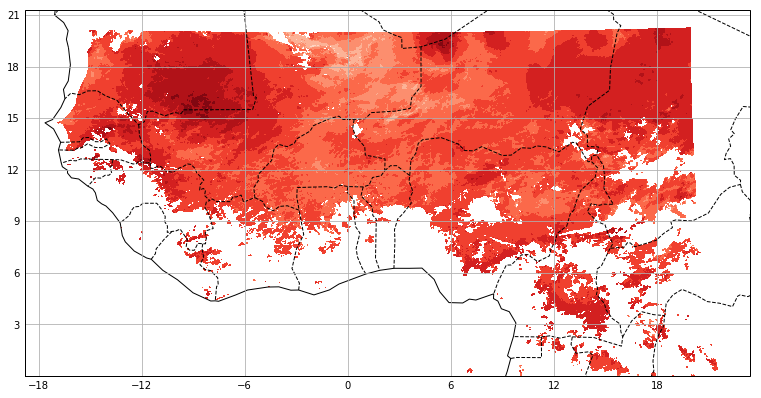

In [262]:
f = plt.figure(figsize=(13,9))
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
ax.contourf(dat.lon.values, dat.lat.values, dat['lsta'].values, cmap='Reds')
ax.coastlines()   ## adds coastlines
#plt.plot(spos[0], spos[1], 'bo')
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
#f.savefig('/home/ck/DIR/cornkle/data/NFLICS/NFLICS_lsta_test.png')

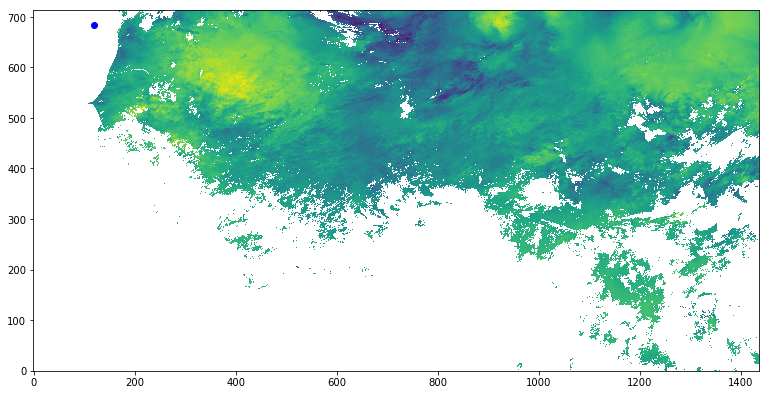

In [263]:
f = plt.figure(figsize=(13,9))
plt.imshow(dat['lsta'].values, origin='lower')
plt.plot(spos[1], spos[0], 'bo')
plt.title('Blue dot should be at the coastline')

In [150]:
dat.lon[spos]

<xarray.DataArray 'lon' ()>
array(-16.4773)
Coordinates:
    lat        float64 19.32
    lon        float64 -16.48
    WA_COLUMN  int64 120
    WA_ROW     int64 685

In [157]:
dat.lat.values.shape

(714, 1436)

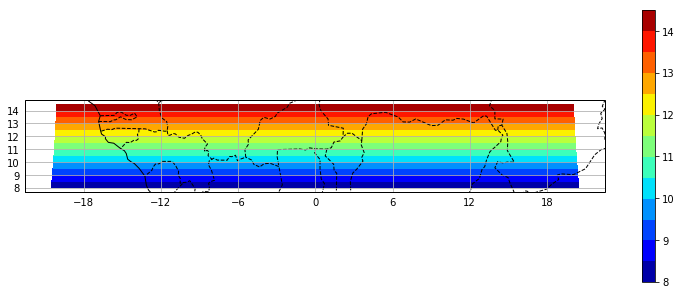

In [177]:
f = plt.figure(figsize=(13,5))
ax = f.add_subplot(111, projection=ccrs.PlateCarree())
mappable = ax.contourf(dat.lon.values, dat.lat.values, dat.lat.values, transform=ccrs.PlateCarree(), cmap='jet', levels=np.arange(8,15,0.5))
ax.coastlines()   ## adds coastlines
plt.colorbar(mappable)
# Gridlines
xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
xl.xlabels_top = False   ## labels off
xl.ylabels_right = False
# Countries
ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
#f.savefig('/home/ck/DIR/cornkle/data/NFLICS/NFLICS_lsta_test.png')